# Introduction

This notebook presents a deep learning project for classifying images as dogs or cats. Transfer learning with the InceptionV3 model is applied to achieve high prediction quality with fewer training epochs. To enhance interpretability, Grad-CAM is employed to visualize the image regions that most influence the model’s predictions, confirming that the network focuses on relevant and meaningful features.

# Download dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("karakaggle/kaggle-cat-vs-dog-dataset")

print("Path to dataset files:", path)


In [5]:
!cp  -rf  /kaggle/input/kaggle-cat-vs-dog-dataset/* .

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Preparing dataset to use




In [1]:
import os
import cv2
dog_imgs=[]
for img in os.listdir("kagglecatsanddogs_3367a/PetImages/Dog"):
    if(".jpg" in img[-4:] ):
      try:
        dim=cv2.imread("kagglecatsanddogs_3367a/PetImages/Dog/"+img).shape
        if(len(dim)>=3 and dim[0]>0 and dim[1]>0):
          dog_imgs.append("kagglecatsanddogs_3367a/PetImages/Dog/"+img)
      except:
        pass

cat_imgs=[]
for img in os.listdir("kagglecatsanddogs_3367a/PetImages/Cat"):
    if(".jpg" in img[-4:] ):
      try:
        dim=cv2.imread("kagglecatsanddogs_3367a/PetImages/Cat/"+img).shape
        if(len(dim)>=3 and dim[0]>0 and dim[1]>0):
            cat_imgs.append("kagglecatsanddogs_3367a/PetImages/Cat/"+img)
      except:
        pass



Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


In [2]:
import pandas as pd
import numpy as np
label=([np.array([0.0,1.0])]*len(cat_imgs))+([np.array([1.0,0.0])]*len(dog_imgs))
df=pd.DataFrame.from_dict({'img':cat_imgs+dog_imgs,'label':label})
df=df.sample(n=len(df), random_state=1)

## Split dataset in train and test



In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test= train_test_split( df, test_size=0.33, random_state=42)

# Defining the model

In [22]:
image_dim=(224,224)

## Data generator

In [5]:
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import random
import pandas as pd
import cv2
import os
import numpy as np
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(   self,
                    df_train,
                    batch_size=16,
                    shuffle=True,
                    image_dim=(299,299)):

        self.batch_size = batch_size

        self.shuffle = shuffle
        self.__random_state=0
        self.__image_dim=image_dim
        self.___df_train=df_train

        self.on_epoch_end()


    def get_image_dim(self):
        return self.__image_dim


    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.___df_train) / self.batch_size))


    def __load_image_as_matrix(self,image_filename,resize_image=True,use_dataset_of_the_project=True):
        im1=cv2.imread(image_filename)
        im1=cv2.resize(im1,(self.__image_dim[1],self.__image_dim[0]),interpolation=cv2.INTER_CUBIC)
        a=im1[:,:,0].copy()
        b=im1[:,:,2].copy()
        im1[:,:,0]=b
        im1[:,:,2]=a
        im1=tf.keras.applications.inception_v3.preprocess_input(np.array(im1,dtype=np.float32))
        return im1



    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch

        df=self.___df_train
        df_batch=df[index*self.batch_size:(index+1)*self.batch_size]
        X=np.zeros((len(df_batch),self.__image_dim[0],self.__image_dim[1],3),dtype=float)
        y=np.zeros((len(df_batch),2),dtype=float)
        for i in range(len(df_batch)):
            img= self.__load_image_as_matrix(df_batch.iloc[i]['img'])
            label= df_batch.iloc[i]['label']
            X[i,:,:,:]=img[:,:,:]
            y[i,:]=label[:]



        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'

        if self.shuffle == True:
            self.___df_train=self.___df_train.sample(n=len(self.___df_train), random_state=self.__random_state)

        self.__random_state=self.__random_state+1

2025-04-28 21:09:45.715832: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-28 21:09:55.900922: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Model architeture

In [6]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten
def model_cat_dog_transfer_learning(base_model,image_dim):
  flatten_layer = Flatten()
  model = base_model.output
  model = Flatten(name="flatten")(model)
  model=Dense(512, activation='relu')(model)
  model=Dropout(0.2)(model)
  model=BatchNormalization()(model)
  model=Dense(512, activation='relu')(model)
  model=Dropout(0.2)(model)
  model=BatchNormalization()(model)
  model=Dense(512, activation='relu')(model)
  model=Dropout(0.2)(model)
  model=BatchNormalization()(model)
  model=Dense(512, activation='relu')(model)
  model=Dropout(0.2)(model)
  model=BatchNormalization()(model)
  model=Dense(2, activation='softmax')(model)
  model_final = Model(inputs=base_model.input, outputs=model)

  opt=tf.keras.optimizers.Adam(learning_rate=0.0001)
  model_final.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model_final



# Train model

In [7]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import InceptionResNetV2
import tensorflow as tf
dataGenerator=DataGenerator(X_train,image_dim=image_dim)
dataGenerator_val=DataGenerator(X_test,image_dim=image_dim)
print(dataGenerator.get_image_dim())
#base_model = VGG16(include_top=False,weights='imagenet', input_shape=(image_dim[0],image_dim[1],3))
base_model = InceptionV3(include_top=False,weights='imagenet', input_shape=(dataGenerator.get_image_dim()[0],dataGenerator.get_image_dim()[1],3))
#base_model = InceptionResNetV2(include_top=False,weights='imagenet', input_shape=(dataGenerator.get_image_dim()[0],dataGenerator.get_image_dim()[1],3))
base_model.trainable = True ## Not trainable weights
model_cat_dog01=model_cat_dog_transfer_learning(base_model,dataGenerator.get_image_dim())
model_cat_dog01.fit(dataGenerator,
                    validation_data=dataGenerator_val,
                    epochs=2)

(224, 224)


2025-04-28 21:10:08.250692: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-28 21:10:16.366142: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-28 21:10:16.366218: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-28 21:10:16.372346: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-28 21:10:16.372461: I external/local_xla/xla/stream_executor

Epoch 1/2


I0000 00:00:1745885459.510906   38224 service.cc:145] XLA service 0x7f13e8002170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745885459.511016   38224 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-04-28 21:11:00.832716: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-28 21:11:06.248161: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2025-04-29 00:06:41.624969: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng28{k2=3,k3=0} for conv (f32[16,32,111,111]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,224,224]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_q

 168/1043 ━━━━━━━━━━━━━━━━━━━━ 15:23:53 63s/step - accuracy: 0.7844 - loss: 0.4675 

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 212/1043 ━━━━━━━━━━━━━━━━━━━━ 11:35:27 50s/step - accuracy: 0.8009 - loss: 0.4364

Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


 256/1043 ━━━━━━━━━━━━━━━━━━━━ 9:05:45 42s/step - accuracy: 0.8127 - loss: 0.4144 

Corrupt JPEG data: 254 extraneous bytes before marker 0xd9


 360/1043 ━━━━━━━━━━━━━━━━━━━━ 5:37:32 30s/step - accuracy: 0.8323 - loss: 0.3792

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 404/1043 ━━━━━━━━━━━━━━━━━━━━ 4:41:42 26s/step - accuracy: 0.8386 - loss: 0.3674

 724/1043 ━━━━━━━━━━━━━━━━━━━━ 1:19:14 15s/step - accuracy: 0.8678 - loss: 0.3121

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 894/1043 ━━━━━━━━━━━━━━━━━━━━ 30:09 12s/step - accuracy: 0.8773 - loss: 0.2941

Corrupt JPEG data: 399 extraneous bytes before marker 0xd9


 934/1043 ━━━━━━━━━━━━━━━━━━━━ 21:08 12s/step - accuracy: 0.8792 - loss: 0.2906

Corrupt JPEG data: 226 extraneous bytes before marker 0xd9


1015/1043 ━━━━━━━━━━━━━━━━━━━━ 5:00 11s/step - accuracy: 0.8826 - loss: 0.2841

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1043/1043 ━━━━━━━━━━━━━━━━━━━━ 664s 559ms/step - accuracy: 0.8838 - loss: 0.2819 - val_accuracy: 0.9667 - val_loss: 0.0974
Epoch 2/2
  47/1043 ━━━━━━━━━━━━━━━━━━━━ 1:21 82ms/step - accuracy: 0.9612 - loss: 0.1102

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


 175/1043 ━━━━━━━━━━━━━━━━━━━━ 14:36:08 61s/step - accuracy: 0.9630 - loss: 0.1068

Corrupt JPEG data: 254 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


 297/1043 ━━━━━━━━━━━━━━━━━━━━ 7:23:03 36s/step - accuracy: 0.9639 - loss: 0.1039

 367/1043 ━━━━━━━━━━━━━━━━━━━━ 5:24:51 29s/step - accuracy: 0.9642 - loss: 0.1032

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 490/1043 ━━━━━━━━━━━━━━━━━━━━ 3:19:05 22s/step - accuracy: 0.9644 - loss: 0.1033

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 605/1043 ━━━━━━━━━━━━━━━━━━━━ 2:07:47 18s/step - accuracy: 0.9646 - loss: 0.1025

Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


1001/1043 ━━━━━━━━━━━━━━━━━━━━ 7:25 11s/step - accuracy: 0.9650 - loss: 0.1012 

Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1043/1043 ━━━━━━━━━━━━━━━━━━━━ 119s 114ms/step - accuracy: 0.9650 - loss: 0.1011 - val_accuracy: 0.9649 - val_loss: 0.0897


In [ ]:
model_cat_dog01.summary()

## Save the model and the test and train sub datasets

In [10]:
X_test.to_parquet('test_data__InceptionV3_224_224.parquet',index=False)
X_train.to_parquet('train_data__InceptionV3_224_224.parquet',index=False)
model_cat_dog01.save('InceptionV3_224_224.keras')

2025-04-28 21:38:11.174977: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 104857600 exceeds 10% of free system memory.
2025-04-28 21:38:14.540345: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 104857600 exceeds 10% of free system memory.
2025-04-28 21:38:19.519512: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 104857600 exceeds 10% of free system memory.


In [1]:
import tensorflow as tf
model_cat_dog01=tf.keras.models.load_model('InceptionV3_224_224.keras')

2025-04-28 21:43:30.550046: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-28 21:43:35.655143: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2025-04-28 21:43:42.812914: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-28 21:43:42.993874: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-28 21:43:42.993949: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] co

## Evaluating the Model’s Performance

In [2]:
import ast
import pandas as pd
df_test = pd.read_parquet('test_data__InceptionV3_224_224.parquet')


In [21]:
def load_image_as_matrix(image_filename,image_dim,resize_image=True,use_dataset_of_the_project=True):
        im1=cv2.imread(image_filename)
        im1=cv2.resize(im1,(image_dim[1],image_dim[0]),interpolation=cv2.INTER_CUBIC)
        a=im1[:,:,0].copy()
        b=im1[:,:,2].copy()
        im1[:,:,0]=b
        im1[:,:,2]=a
        im1=tf.keras.applications.inception_v3.preprocess_input(np.array(im1,dtype=np.float32))
        return im1

In [12]:
import numpy as np
import tqdm
import cv2


y_true = []
y_pred = []

for idx in tqdm.tqdm(range(len(df_test))):
    row= df_test.iloc[idx]
    img_path = row['img']
    label = row['label']

    # Convert one-hot to class index
    if isinstance(label, list) or isinstance(label, np.ndarray):
        label_idx = np.argmax(label)
    else:
        label_idx = np.argmax(eval(label))  # if stored as string like '[0,1]'

    image = load_image_as_matrix(img_path, image_dim)
    prediction = model_cat_dog01.predict(np.array([image],dtype=float), verbose=False)
    pred_idx = np.argmax(prediction, axis=1)[0]

    y_true.append(label_idx)
    y_pred.append(pred_idx)
df_to_use_in_mat_conf=pd.DataFrame({"y_true":y_true,"y_pred":y_pred})
df_to_use_in_mat_conf.to_parquet('df_to_use_in_mat_conf.parquet',index=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8222/8222 [12:57<00:00, 10.57it/s]


### Confusion Matrix

In [20]:
from sklearn.metrics import confusion_matrix
df_to_use_in_mat_conf= pd.read_parquet('df_to_use_in_mat_conf.parquet')
pd.DataFrame(confusion_matrix(df_to_use_in_mat_conf['y_true'],df_to_use_in_mat_conf['y_pred']),columns=[['predicted','predicted'],['dog','cat']], index=[['real','real'],['dog','cat']])


predicted      
               dog   cat
real dog      4050    76
     cat       212  3884

The confusion matrix shows that the model demonstrates good predictive performance, with a low number of incorrectly predicted elements.

### Grad-CAM
We will use the Grad-CAM method to analyze, based on a small sample of images, which regions of the images the trained neural network considers most important for inferring whether they depict a dog or a cat. This analysis involves selecting a convolutional layer from the trained neural network and, using the data extracted from this layer during the inference process, constructing a heatmap that highlights the regions the network deemed most relevant for making its classification. As is commonly done, the following code performs the analysis on the last convolutional layer of the trained neural network.


In [18]:
from keras import backend as K
import keras
import matplotlib.pyplot as plt
def classActivationMap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    conv_layer_output_value=heatmap.numpy()

    #plt.imshow(heatmap)
    #plt.show()
    heatmap = cv2.resize(conv_layer_output_value, (img_array[0].shape[1], img_array[0].shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    x=heatmap[:,:,0].copy()
    y=heatmap[:,:,2].copy()
    heatmap[:,:,0]=y
    heatmap[:,:,2]=x

    return heatmap

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10524s 10524s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


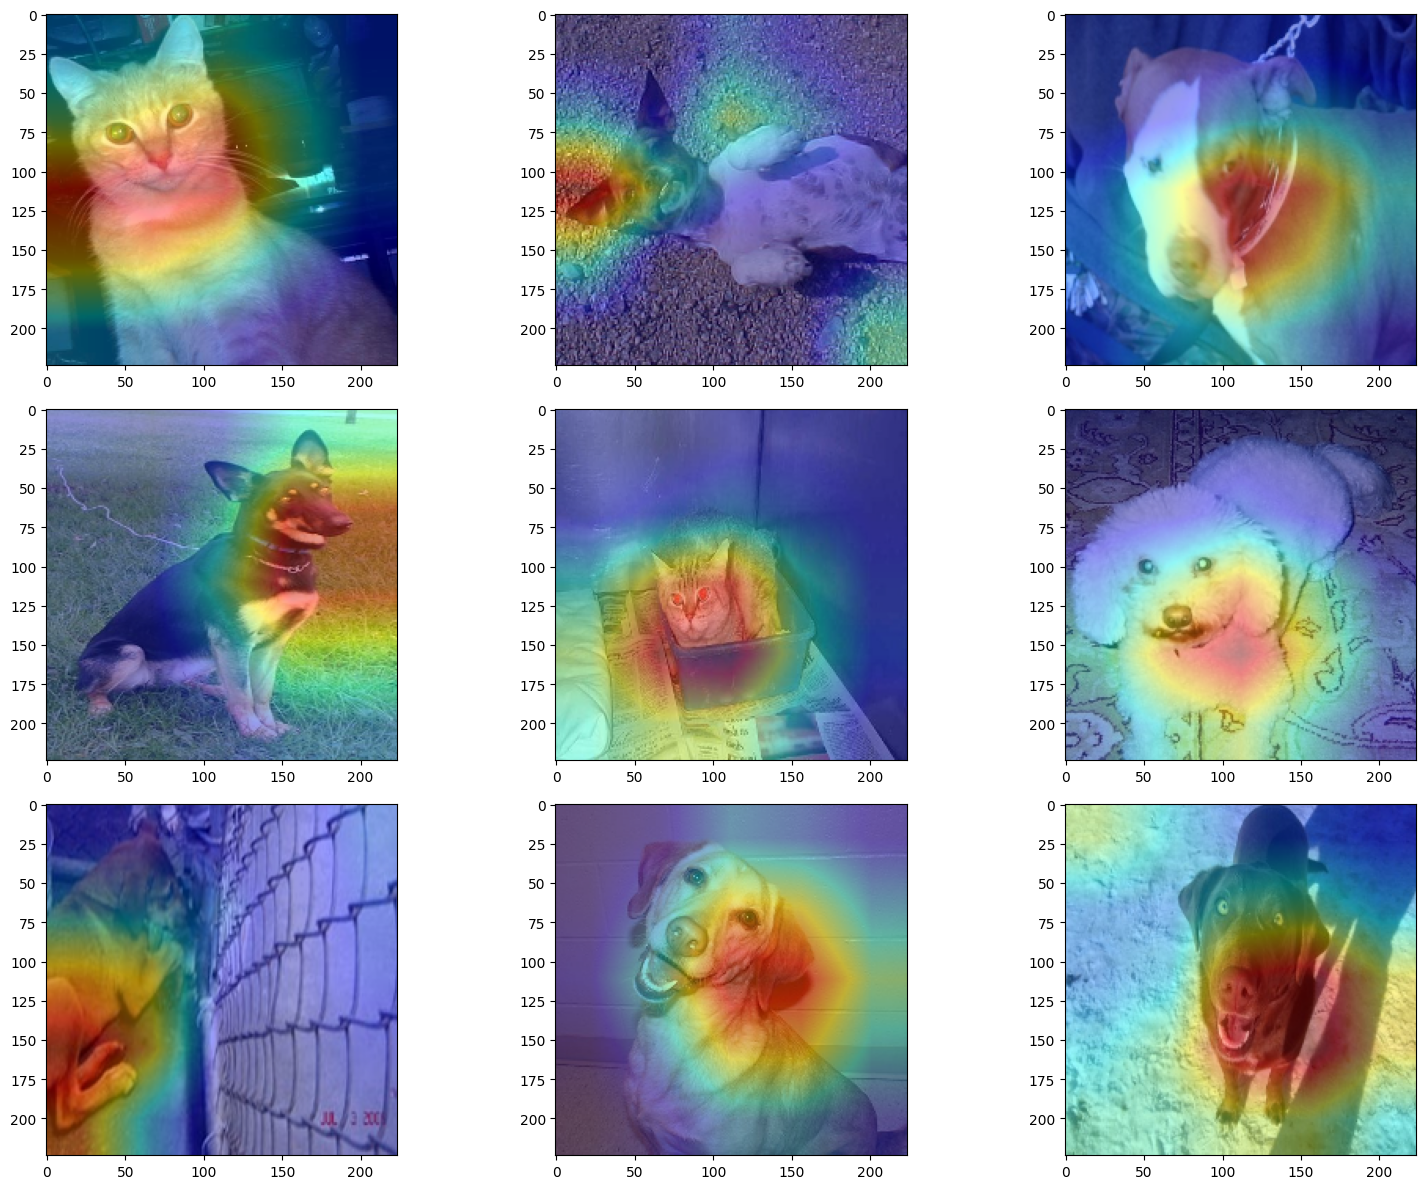

In [28]:
import numpy as np
n_rows = 3
n_cols = 3
plt.figure(figsize=(16, 12))  # Bigger figure (width, height)
for i in range(n_rows*n_cols):
    x=np.array([load_image_as_matrix(df_test.iloc[i]['img'],image_dim)],dtype=float)
    pred=model_cat_dog01.predict(x)[0]
    heatmap=classActivationMap(x,model_cat_dog01,"mixed10")

    x=x[0]
    x=np.uint8(np.round(((x+1)/2)*255))
    final_img=np.uint8(np.round((x*0.6)+(heatmap*0.4)))
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(final_img)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

Based on the results presented, it can be observed that the trained neural network focuses on truly relevant regions of the images for classification. In the images analyzed, the network consistently identified the animal’s body as the most important region for classification, with the animal’s head being considered, in most cases, the most significant part of the body for determining the image category.

# Conclusion

The results obtained demonstrate that the trained neural network achieves high-quality classification performance, as evidenced by the confusion matrix metrics. Additionally, the Grad-CAM visualizations confirm that the model consistently focuses on meaningful and relevant regions of the images, particularly the animal’s body and head, when making predictions. These findings indicate that the combination of transfer learning with the InceptionV3 model and Grad-CAM analysis successfully produced a robust and interpretable image classifier for distinguishing between cats and dogs.